#### AIRBNB NOTEBOOK

## Libraries

In [1]:
#Get the Basics
%autosave 60
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import datetime
import time
import pygments

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import folium as fo
import wordcloud as wo
import plotly as plo

#Scaling nicely
from sklearn.preprocessing import StandardScaler

#Models to be used
from sklearn.linear_model import LinearRegression


#Select relevant features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Select best model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



Autosaving every 60 seconds


## Helper functions

In [2]:
def check_data(data):
    for column in data.columns.values:
        print("\n- {} :  \n\tunique values: {}\n\tnull values: {}".format(
              column,
              len(data[column].unique()),
              data[column].isnull().sum()))

def remove_dollar(data):
    data = data.apply(str)
    data = [float(x.strip('$').replace(',','')) for x in data]
    return data

def convert_boolstr(data):
    return data.map(dict(t=1, f=0))

def get_month(date):
    new_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return new_date.strftime("%b")

def get_epoch(date):
    new_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return time.mktime(new_date.timetuple())

def setcolor_by_price(price,price_range):
    if price == 0:
        color = 'lightgrey'
    elif price in price_range.cat.categories[0]:
        color = 'lightred'
    elif price in price_range.cat.categories[1]:
        color = 'red'
    elif price in price_range.cat.categories[2]:
        color = 'darkred'
    else:
        color = 'black'
    return color

## Data Engineering

In [3]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

### Calendar

In [4]:
calendar.shape
calendar.head() 

(1393570, 4)

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

#### Native data state:
- date is at day precision (a bit to much to get something considering 1393570 datapoints
- price contains "$"...
- t/f for a boolean, needs to be converted to 1/0

In [5]:
# Formating calendar data to be useful
calendar.price = remove_dollar(calendar.price)
calendar.available = convert_boolstr(calendar.available)
check_data(calendar)    
calendar.head()


- listing_id :  
	unique values: 3818
	null values: 0

- date :  
	unique values: 365
	null values: 0

- available :  
	unique values: 2
	null values: 0

- price :  
	unique values: 670
	null values: 459028


listing_id        date  available  price
0      241032  2016-01-04          1   85.0
1      241032  2016-01-05          1   85.0
2      241032  2016-01-06          0    NaN
3      241032  2016-01-07          0    NaN
4      241032  2016-01-08          0    NaN

- 365 unique date values, this is on year timeframe (period 2016-2017)
- There are only 670 different prices for 3818 unique listings

## Q1 - What is the price evolution over the year ?

In [6]:
calendar_price = calendar  #calendar.loc[calendar['available']==1];
calendar_price['month'] = [get_month(x) for x in calendar_price['date']];
calendar_price = calendar_price.drop(['date'],axis=1);
print("Reduction of {0:.2f} %".format((calendar.shape[0] - calendar_price.shape[0]) * 100 / 
                                  calendar.shape[0]))
calendar_price.isnull().sum()
calendar_price.describe()

Reduction of 0.00 %


listing_id         0
available          0
price         459028
month              0
dtype: int64

listing_id     available          price
count  1.393570e+06  1.393570e+06  934542.000000
mean   5.550111e+06  6.706100e-01     137.944859
std    2.962274e+06  4.699919e-01     105.062870
min    3.335000e+03  0.000000e+00      10.000000
25%    3.258213e+06  0.000000e+00      75.000000
50%    6.118244e+06  1.000000e+00     109.000000
75%    8.035212e+06  1.000000e+00     160.000000
max    1.034016e+07  1.000000e+00    1650.000000

- By converting date format to months reduced dataset size of about 33%
- Price is around 138 dollars with a standard deviation of 105 dollars (some big outlierd of about 10 times the mean)

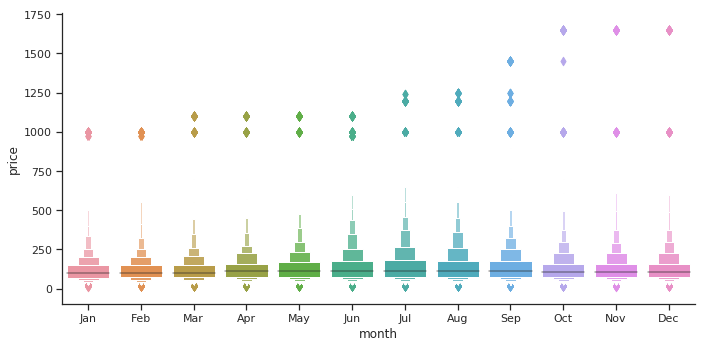

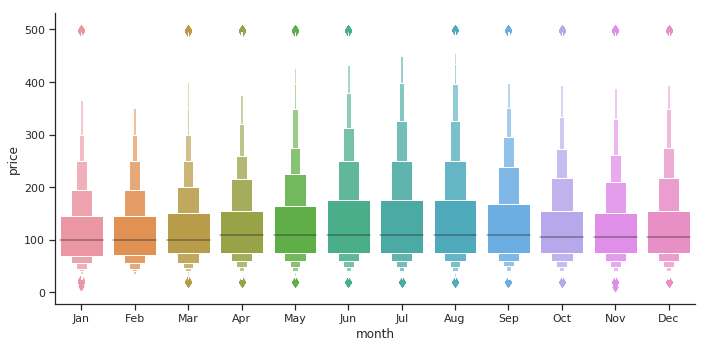

In [7]:
# Display
sns.set(style="ticks",color_codes=True)
sns.catplot(x="month", y="price", kind='boxen', data=calendar_price[calendar['available']==1],height=5,aspect=2);
price_without_outlier = calendar[calendar_price['price'] < 500];
sns.catplot(x="month", y="price", kind='boxen', data=price_without_outlier[price_without_outlier['available']==1],height=5,aspect=2);

If we look at the price per month we see larger distributions around summer holidays and some outliers
during winter with price jumps around the year revealing maybe different characteristics / standings

There are the same number of unique listings across the months


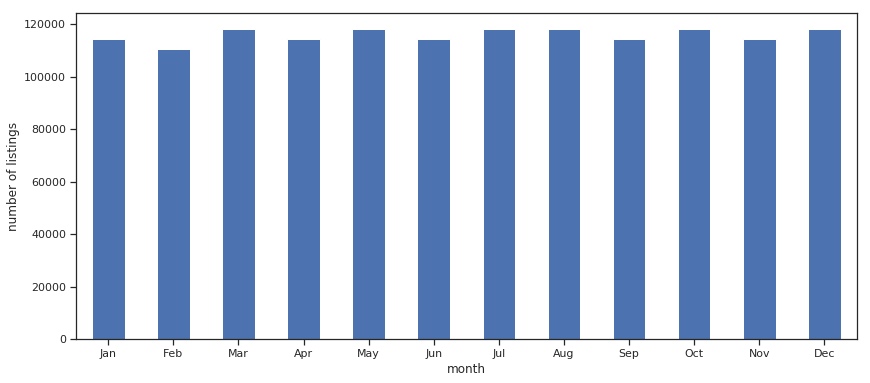

In [8]:
calendar_listings = calendar_price[['month','listing_id']].groupby(['month'],sort=False)['listing_id'].count()
calendar_listings_unique = calendar_price[['month','listing_id']].groupby(['month'],sort=False)['listing_id'].unique()
for element in calendar_listings_unique:
    same_listings =True 
    if len(element) != len(calendar_price['listing_id'].unique()):
        same_listings = False
        break
if same_listings:
    print('There are the same number of unique listings across the months')
sns.set_style()
calendar_listings.head()
ax = calendar_listings.plot.bar(figsize=(14,6),rot=0);
ax.set_ylabel('number of listings');

Property listings varies by about 1% across the year with an all year low around february

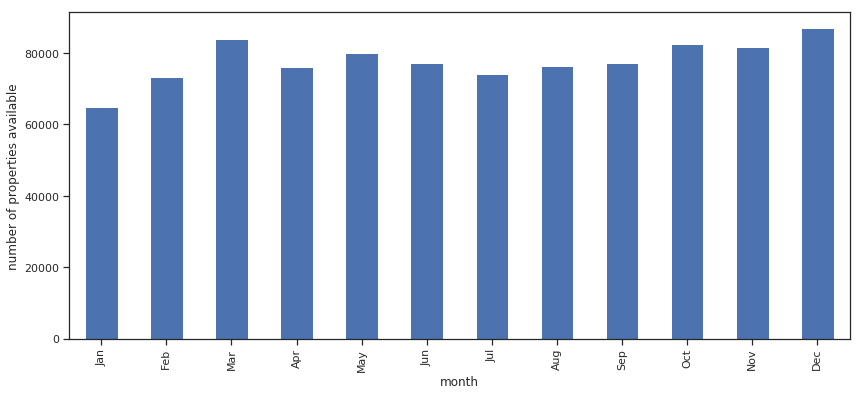

In [9]:
calendar_avail = calendar[calendar_price['available'] == 1];
calendar_avail = calendar_avail.groupby('month',sort=False)['available'].count()
ax = calendar_avail.plot.bar(figsize=(14,6));
ax.set_ylabel('number of properties available');

Listing of available properties is all year law in January followed July

## Listings

In [10]:
print(listings.shape)
check_data(listings)    
listings.head()

(3818, 92)

- id :  
	unique values: 3818
	null values: 0

- listing_url :  
	unique values: 3818
	null values: 0

- scrape_id :  
	unique values: 1
	null values: 0

- last_scraped :  
	unique values: 1
	null values: 0

- name :  
	unique values: 3792
	null values: 0

- summary :  
	unique values: 3479
	null values: 177

- space :  
	unique values: 3120
	null values: 569

- description :  
	unique values: 3742
	null values: 0

- experiences_offered :  
	unique values: 1
	null values: 0

- neighborhood_overview :  
	unique values: 2507
	null values: 1032

- notes :  
	unique values: 2000
	null values: 1606

- transit :  
	unique values: 2575
	null values: 934

- thumbnail_url :  
	unique values: 3499
	null values: 320

- medium_url :  
	unique values: 3499
	null values: 320

- picture_url :  
	unique values: 3818
	null values: 0

- xl_picture_url :  
	unique values: 3499
	null values: 320

- host_id :  
	unique values: 2751
	null values: 0

- host_url :  
	unique values: 2751
	null valu

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                NaN   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                NaN   
4                                          Belltown    

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                NaN   
4  The nearest public transit bus (D Line) is 2 b...   

                                       thumbnail_url  \
0                                                NaN   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                          medium_url  \
0                                                NaN   
1  https://a0.muscache.com/im/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         picture_url  \
0  https://a1.muscache.com/ac/pictures/67560560/c...   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2  https://a2.muscache.com/ac/pictures/b4324e0f-a...   
3  https://a0.muscache.com/ac/pictures/94146944/6...   
4  https://a1.muscache.com/ac/pictures/6120468/b0...   

                                      xl_picture_url   host_id  \
0                                                

In [11]:
# Removing uselss data for column in listings.columns.values:
for column in listings.columns.values:
    if len(listings[column].unique()) == 1:
        listings = listings.drop(column,axis=1)
        print("Removed ",column)

listings.shape
listings.describe()

Removed  scrape_id
Removed  last_scraped
Removed  experiences_offered
Removed  market
Removed  country_code
Removed  country
Removed  has_availability
Removed  calendar_last_scraped
Removed  requires_license
Removed  license
Removed  jurisdiction_names


(3818, 81)

id       host_id  host_listings_count  \
count  3.818000e+03  3.818000e+03          3816.000000   
mean   5.550111e+06  1.578556e+07             7.157757   
std    2.962660e+06  1.458382e+07            28.628149   
min    3.335000e+03  4.193000e+03             1.000000   
25%    3.258256e+06  3.275204e+06             1.000000   
50%    6.118244e+06  1.055814e+07             1.000000   
75%    8.035127e+06  2.590309e+07             3.000000   
max    1.034016e+07  5.320861e+07           502.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                3816.000000  3818.000000  3818.000000   3818.000000   
mean                    7.157757    47.628961  -122.333103      3.349398   
std                    28.628149     0.043052     0.031745      1.977599   
min                     1.000000    47.505088  -122.417219      1.000000   
25%                     1.000000    47.609418  -122.354320      2.000000   
50%                     1.000000    47.623601  -122.328874      3.000000   
75%                     3.000000    47.662694  -122.310800      4.000000   
max                   502.000000    47.733358  -122.240607     16.000000   

         bathrooms     bedrooms         beds  square_feet  guests_included  \
count  3802.000000  3812.000000  3817.000000    97.000000      3818.000000   
mean      1.259469     1.307712     1.735394   854.618557         1.672603   
std       0.590369     0.883395     1.139480   671.404893         1.311040   
min       0.000000     0.000000     1.000000     0.000000         0.000000   
25%       1.000000     1.000000     1.000000   420.000000         1.000000   
50%       1.000000     1.000000     1.000000   750.000000         1.000000   
75%       1.000000     2.000000     2.000000  1200.000000         2.000000   
max       8.000000     7.000000    15.000000  3000.000000        15.000000   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count     3818.000000     3818.000000      3818.000000      3818.000000   
mean         2.369303      780.447617        16.786276        36.814825   
std         16.305902     1683.589007        12.173637        23.337541   
min          1.000000        1.000000         0.000000         0.000000   
25%          1.000000       60.000000         2.000000        13.000000   
50%          2.000000     1125.000000        20.000000        46.000000   
75%          2.000000     1125.000000        30.000000        59.000000   
max       1000.000000   100000.000000        30.000000        60.000000   

       availability_90  availability_365  number_of_reviews  \
count      3818.000000       3818.000000        3818.000000   
mean         58.082504        244.772656          22.223415   
std          34.063845        126.772526          37.730892   
min           0.000000          0.000000           0.000000   
25%          28.000000        124.000000           2.000000   
50%          73.000000        308.000000           9.000000   
75%          89.000000        360.000000          26.000000   
max          90.000000        365.000000         474.000000   

       review_scores_rating  review_scores_accuracy  \
count           3171.000000             3160.000000   
mean              94.539262                9.636392   
std                6.606083                0.698031   
min               20.000000                2.000000   
25%               93.000000                9.000000   
50%               96.000000               10.000000   
75%               99.000000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                3165.000000            3160.000000   
mean                    9.556398               9.786709   
std                     0.797274               0.595499   
min                     3.000000               2.000000   
25%                     9.000000              10.000000   
50%         

In [12]:
# Converting bool and removing dollars
boolean_str =['host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable',
              'require_guest_profile_picture','require_guest_phone_verification']

for column in boolean_str:
    listings[column] = convert_boolstr(listings[column])
    
prices = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for column in prices:
    listings[column] = remove_dollar(listings[column])

In [13]:
# Display
check_data(listings)
listings.shape


- id :  
	unique values: 3818
	null values: 0

- listing_url :  
	unique values: 3818
	null values: 0

- name :  
	unique values: 3792
	null values: 0

- summary :  
	unique values: 3479
	null values: 177

- space :  
	unique values: 3120
	null values: 569

- description :  
	unique values: 3742
	null values: 0

- neighborhood_overview :  
	unique values: 2507
	null values: 1032

- notes :  
	unique values: 2000
	null values: 1606

- transit :  
	unique values: 2575
	null values: 934

- thumbnail_url :  
	unique values: 3499
	null values: 320

- medium_url :  
	unique values: 3499
	null values: 320

- picture_url :  
	unique values: 3818
	null values: 0

- xl_picture_url :  
	unique values: 3499
	null values: 320

- host_id :  
	unique values: 2751
	null values: 0

- host_url :  
	unique values: 2751
	null values: 0

- host_name :  
	unique values: 1467
	null values: 2

- host_since :  
	unique values: 1381
	null values: 2

- host_location :  
	unique values: 121
	null values: 8

- ho

(3818, 81)

In [14]:
listings.head()

id                           listing_url  \
0   241032   https://www.airbnb.com/rooms/241032   
1   953595   https://www.airbnb.com/rooms/953595   
2  3308979  https://www.airbnb.com/rooms/3308979   
3  7421966  https://www.airbnb.com/rooms/7421966   
4   278830   https://www.airbnb.com/rooms/278830   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description  \
0  Make your self at home in this charming one-be...   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                NaN   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                NaN   
4                                          Belltown    

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                NaN   
4  The nearest public transit bus (D Line) is 2 b...   

                                       thumbnail_url  \
0                                                NaN   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                          medium_url  \
0                                                NaN   
1  https://a0.muscache.com/im/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         picture_url  \
0  https://a1.muscache.com/ac/pictures/67560560/c...   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2  https://a2.muscache.com/ac/pictures/b4324e0f-a...   
3  https://a0.muscache.com/ac/pictures/94146944/6...   
4  https://a1.muscache.com/ac/pictures/6120468/b0...   

                                      xl_picture_url   host_id  \
0                                                NaN    956883   
1  https://a0.muscache.com/ac/pictures/14409893/f...   5177328   
2                                                NaN  16708587   
3                                                NaN   9851441   
4                                                NaN   1452570   

            

## Reviews

In [15]:
print(reviews.shape)
reviews.head()

(84849, 6)


listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

In [16]:
check_data(reviews)    
reviews['date'] = [x[:-3] for x in reviews['date']]


- listing_id :  
	unique values: 3191
	null values: 0

- id :  
	unique values: 84849
	null values: 0

- date :  
	unique values: 1930
	null values: 0

- reviewer_id :  
	unique values: 75730
	null values: 0

- reviewer_name :  
	unique values: 14380
	null values: 0

- comments :  
	unique values: 84137
	null values: 18


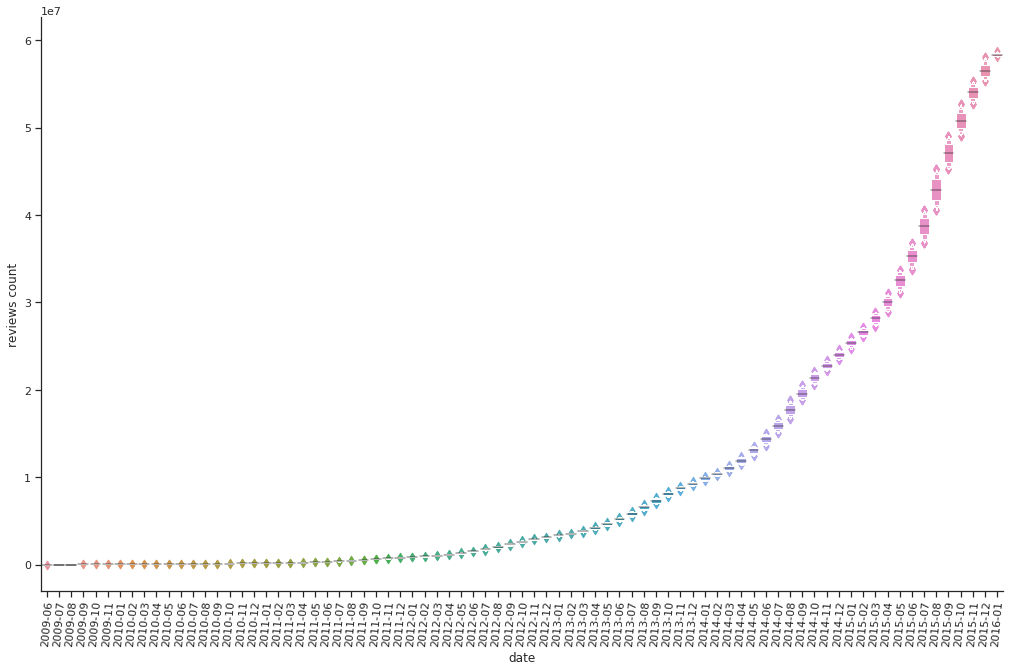

In [17]:
reviews_desc = reviews[['listing_id','id','date']]
reviews_evolution = reviews_desc.groupby(['date']).count()
reviews_evolution.head()
reviews_evolution.shape
sns.set(style="ticks", color_codes=True);
cp = sns.catplot(x="date", y="id", kind='boxen', data=reviews_desc.sort_values('date'),height=5,aspect=2);
cp.set_xticklabels(rotation=85);
cp.fig.set_size_inches(15,10);
cp.ax.set_ylabel('reviews count');

We can see a steep increase of the number of reviews on the full dataset which could be associated to the increasing popularity of AirBnb

In [18]:
listings['id'].describe()
calendar['listing_id'].describe()
#Identical listings

count    3.818000e+03
mean     5.550111e+06
std      2.962660e+06
min      3.335000e+03
25%      3.258256e+06
50%      6.118244e+06
75%      8.035127e+06
max      1.034016e+07
Name: id, dtype: float64

count    1.393570e+06
mean     5.550111e+06
std      2.962274e+06
min      3.335000e+03
25%      3.258213e+06
50%      6.118244e+06
75%      8.035212e+06
max      1.034016e+07
Name: listing_id, dtype: float64

## Q2 - Is it more interesting interesting for short term or long term stay?

In [19]:
listings['price'].isnull().sum()
listings['weekly_price'].isnull().sum()
listings['monthly_price'].isnull().sum()

0

1809

2301

In [20]:
daily_p = listings['price']
weekly_p = listings['weekly_price']
monthly_p = listings['monthly_price']

In [21]:
daily_p = daily_p.astype(float)
weekly_p = weekly_p.astype(float)
monthly_p = monthly_p.astype(float)

d_price_ranges = pd.qcut(daily_p,4)
d_price_ranges.cat.categories
w_price_ranges = pd.qcut(weekly_p,4)
w_price_ranges.cat.categories
m_price_ranges = pd.qcut(monthly_p,4)
m_price_ranges.cat.categories
weekly_p = listings['weekly_price'].fillna(0)
monthly_p = listings['monthly_price'].fillna(0)

IntervalIndex([(19.999, 75.0], (75.0, 100.0], (100.0, 150.0], (150.0, 1000.0]],
              closed='right',
              dtype='interval[float64]')

IntervalIndex([(99.999, 455.0], (455.0, 650.0], (650.0, 950.0], (950.0, 6300.0]],
              closed='right',
              dtype='interval[float64]')

IntervalIndex([(499.999, 1512.0], (1512.0, 2200.0], (2200.0, 3150.0], (3150.0, 19500.0]],
              closed='right',
              dtype='interval[float64]')

In [22]:
%%capture
data = listings[['longitude','latitude']];
data['daily_price_color'] = [setcolor_by_price(p,d_price_ranges) 
                             for p in daily_p];
data['weekly_price_color'] = [setcolor_by_price(p,w_price_ranges) 
                              for p in weekly_p];
data['monthly_price_color'] = [setcolor_by_price(p,m_price_ranges) 
                               for p in monthly_p];

In [23]:
%%capture
init = [data['latitude'].mean(),data['longitude'].mean()]
daily_map = fo.Map(location=init,zoom_start=11)
weekly_map = fo.Map(location=init,zoom_start=11)
monthly_map = fo.Map(location=init,zoom_start=11)
data.apply(lambda row:fo.CircleMarker(
                        location=[row["latitude"], row["longitude"]],
                        color=row["daily_price_color"],fill=True,
                        fill_opacity=0.5,
                        opacity=0.4,
                        weight=2,
                        radius=3,
                         ).add_to(daily_map),
                        axis=1)
data.apply(lambda row:fo.CircleMarker(
                        location=[row["latitude"], row["longitude"]],
                        color=row["weekly_price_color"],fill=True,
                        fill_opacity=0.5,
                        opacity=0.4,
                        weight=2,
                        radius=3,
                         ).add_to(weekly_map),
                        axis=1)
data.apply(lambda row:fo.CircleMarker(
                        location=[row["latitude"], row["longitude"]],
                        color=row["monthly_price_color"],fill=True,
                        fill_opacity=0.5,
                        opacity=0.4,
                        weight=2,
                        radius=3,
                         ).add_to(monthly_map),
                        axis=1)

In [24]:
daily_map

In [25]:
weekly_map

In [26]:
monthly_map

We clearly miss data for monthly price and weekly price, as such it seems to be less prone to a monthly rent and more focused on a short term.

[6.05243286]
[46.43783797]
[3.0822999]
[191.83381428]


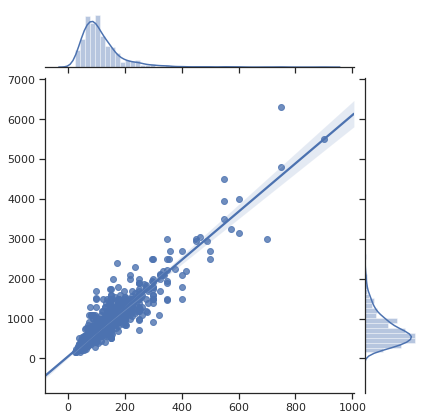

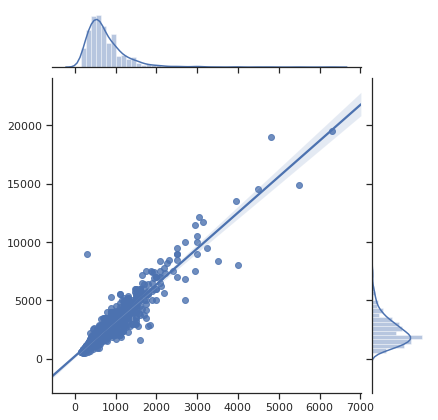

In [27]:
price = listings[['price','weekly_price','monthly_price']].dropna()
from scipy import stats
from sklearn import linear_model

regr = linear_model.LinearRegression();
X = price[['price']]
y = price[['weekly_price']]
regr.fit(X, y);
print(regr.coef_[0])
print(regr.intercept_)

sns.jointplot(price[['price']],price[['weekly_price']],data=price,kind="reg");

regr = linear_model.LinearRegression();
X = price[['weekly_price']]
y = price[['monthly_price']]
regr.fit(X, y);
print(regr.coef_[0])
print(regr.intercept_)
sns.jointplot(price[['weekly_price']],price[['monthly_price']],data=price,kind="reg");

You get about 14% price reduction by staying on a full week and about 25% reduction while staying for a month

## Q3 - What does it take to be the best spot in Seattle?

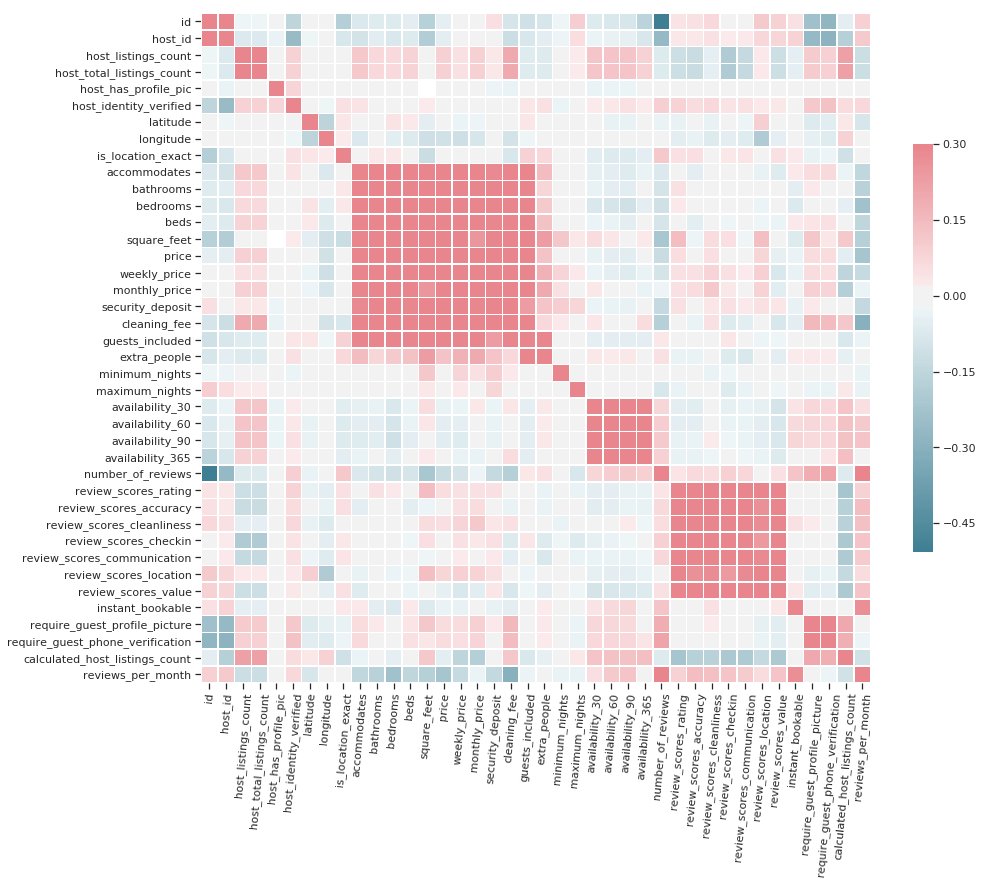

In [28]:
# Compute the correlation matrix
numeric_fields = []
for column in listings.columns.values:
    if listings[column].dtype in ['int64','float64']:
        numeric_fields.append(column)

listings_numerical = listings[numeric_fields]
from sklearn import preprocessing
mima_scaler = preprocessing.MinMaxScaler()
listings_numerical_scaled = mima_scaler.fit_transform(listings_numerical)
listings_numerical_scaled = pd.DataFrame(listings_numerical_scaled,columns=listings_numerical.columns)
corr = listings_numerical_scaled.corr()

#%%
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5});
hm.set_xticklabels(labels=hm.get_xticklabels(),rotation=85);

**Some interesting notes:**
- As expected we see a high correlation between property characteristics and price + additionnal fees
- The number of reviews correlates to the exactitude of the location, square feet, cleaning fee, verification requirements and capacity to be bookable

In [29]:
listings_numerical.review_scores_value.mean()
listings_numerical.review_scores_value.std()

9.452245414294751

0.7502586409581258

In [30]:
get_epoch(listings.first_review[0])
get_epoch(listings.last_review[0])

1320105600.0

1451692800.0

In [31]:
listing_count_by_host = listings.groupby("host_id")['host_total_listings_count'];

In [32]:
print("Std: ",listing_count_by_host.count().std())
print("Average number of listings: ",listing_count_by_host.count().mean())
print("Maximum number of listings: ",listing_count_by_host.count().max())

Std:  2.002970927134483
Average number of listings:  1.387131952017448
Maximum number of listings:  46


In [33]:
listings.columns

Index(['id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'smart_location', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'clean

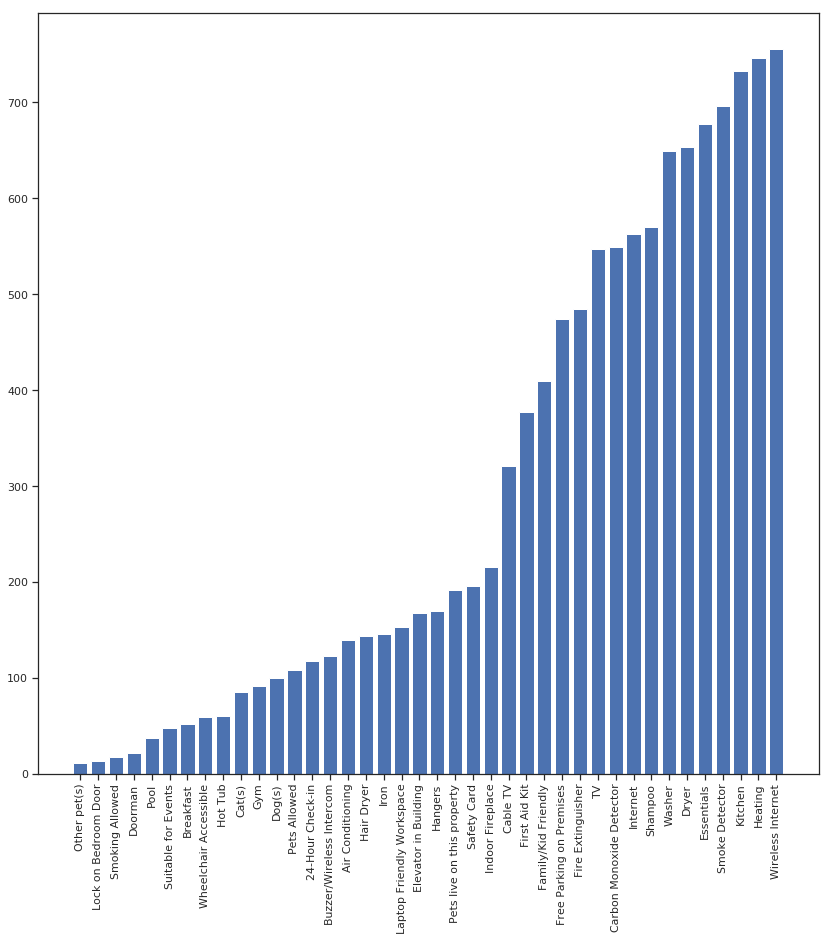

In [34]:
best = listings[listings['review_scores_rating'] == listings['review_scores_rating'].max()]
amenities = dict()
for amenity in best.amenities:
    text = amenity.replace('}','').replace('{','').replace('"','')
    tokens = text.split(',')
    for token in tokens:
        token = token.strip()
        if token != '':
            if token in amenities:
                amenities[token] += 1
            else:
                amenities[token] = 1
            
amenities = {k: v for k,v in sorted(amenities.items(), key=lambda x: x[1])}
plt.figure(figsize=(14,14))
plt.bar(range(len(amenities)),list(amenities.values()),align='center')
plt.xticks(range(len(amenities)),list(amenities.keys()),rotation='vertical');

Top 5 amenities are: 
- Wireless Internet (Wifi is life!), 
- Heating, 
- Kitchen
- Smoke detector
- Essentials [toilet paper, soap, one towel per guest, one pillow per guest, linens for each guest bed]

In [35]:
scores = listings_numerical[['review_scores_rating',
                             'review_scores_accuracy',
                             'review_scores_cleanliness',
                             'review_scores_checkin',
                             'review_scores_communication',
                             'review_scores_location',
                             'review_scores_value']]
scores = scores.dropna()
scores.mean()

review_scores_rating           94.538949
review_scores_accuracy          9.636795
review_scores_cleanliness       9.556048
review_scores_checkin           9.786574
review_scores_communication     9.810956
review_scores_location          9.608930
review_scores_value             9.452185
dtype: float64

Overall seattle properties are well ranked

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

#Lets evaluate categories versus overall review score

In [37]:
X = listings[['property_type','room_type','bathrooms','bedrooms','beds','bed_type','square_feet']]

# We create the preprocessing pipelines for categorical data.
numeric_features = ['bathrooms', 'bedrooms','beds']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value=0))])

numeric_features2 = ['square_feet']
numeric_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['property_type','room_type','bed_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', numeric_transformer, numeric_features),
                        ('num2', numeric_transformer2, numeric_features2),
                        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
forest =  RandomForestClassifier()
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',forest)])

# Labels

y=listings[['review_scores_rating']]
y.fillna(0,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=0, missing_values=nan,
       strategy='constant', verbos...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

model score: 0.158


In [38]:
importances = clf.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:\n")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:

1. feature 2 (0.260640)
2. feature 0 (0.203111)
3. feature 1 (0.148930)
4. feature 3 (0.099695)
5. feature 13 (0.034874)
6. feature 4 (0.032983)
7. feature 17 (0.020155)


Review scores seems to be highly biased as expected and do not provide

### Q4. Can we predict price range from property specs?

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import unique_labels
import math as mat

-------------------------
Data sanity check

price    0
dtype: int64

Text(0, 0.5, 'Price')

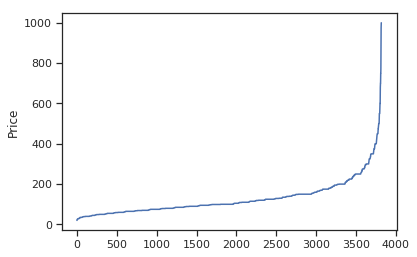

In [83]:
price = listings[['price']]
price.isnull().sum()
price = listings[['price']].sort_values(by='price')
price = price.values
plt.plot(price)
plt.ylabel('Price');
small_price = price[mat.floor(len(price)/3)]
medium_price = price[2*mat.floor(len(price)/3)]
listings['price_range'] = np.nan;
for price in listings['price'].values:
    if price < small_price:
        listings.loc[listings['price']==price,'price_range'] = 'low'
    elif price < medium_price:
        listings.loc[listings['price']==price,'price_range'] = 'medium'
    else:
        listings.loc[listings['price']==price,'price_range'] = 'high'

In [84]:
bed_types = listings['bed_type'].unique()
property_types = listings['property_type'].unique()
room_types = listings['property_type'].unique()
print(bed_types)
print(property_types)
print(room_types)

['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']
['Apartment' 'House' 'Cabin' 'Condominium' 'Camper/RV' 'Bungalow'
 'Townhouse' 'Loft' 'Boat' 'Bed & Breakfast' 'Other' 'Dorm' 'Treehouse'
 'Yurt' 'Chalet' 'Tent' nan]
['Apartment' 'House' 'Cabin' 'Condominium' 'Camper/RV' 'Bungalow'
 'Townhouse' 'Loft' 'Boat' 'Bed & Breakfast' 'Other' 'Dorm' 'Treehouse'
 'Yurt' 'Chalet' 'Tent' nan]


---------------- 
Data Cleaning

In [85]:
listings['num_bed_type'] = listings['bed_type'].astype('category').cat.codes;
listings['num_property_type'] = listings['property_type'].astype('category').cat.codes;
listings['num_room_type'] = listings['room_type'].astype('category').cat.codes;
dataset = listings[['num_property_type','num_room_type','bathrooms','bedrooms','beds','num_bed_type','price_range','latitude','longitude']];
dataset['bathrooms'].fillna(0,inplace=True)
dataset['bedrooms'].fillna(0,inplace=True)
dataset['beds'].fillna(0,inplace=True)
len(dataset)

3818

In [86]:
features = dataset[['num_property_type','num_room_type','bathrooms','bedrooms','beds','num_bed_type','latitude','longitude']];
label = dataset[['price_range']];
train_features, test_features, train_label, test_label = train_test_split(features, label,test_size=0.25);

In [87]:
features = features.astype(float)
features.dtypes

num_property_type    float64
num_room_type        float64
bathrooms            float64
bedrooms             float64
beds                 float64
num_bed_type         float64
latitude             float64
longitude            float64
dtype: object

In [88]:
train_features.isnull().sum()

num_property_type    0
num_room_type        0
bathrooms            0
bedrooms             0
beds                 0
num_bed_type         0
latitude             0
longitude            0
dtype: int64

----------------------
Logistic regression model

In [89]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(train_features,train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [90]:
logreg.predict(test_features);
print("Accuracy is {}".format(logreg.score(train_features,train_label)));

Accuracy is 0.6615438351379672


In [91]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred);

    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if title == None:
        if normalize:
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return cm

In [92]:
from sklearn.metrics import recall_score,precision_score,roc_curve,precision_recall_fscore_support, confusion_matrix, classification_report

#Test classifier
predicted = logreg.predict(test_features)
true = list()
for value in test_label.values:
    true.append(value[0])


              precision    recall  f1-score   support

   Price low       0.77      0.65      0.70       316
Price medium       0.76      0.74      0.75       329
  Price high       0.54      0.63      0.58       310

   micro avg       0.68      0.68      0.68       955
   macro avg       0.69      0.68      0.68       955
weighted avg       0.69      0.68      0.68       955



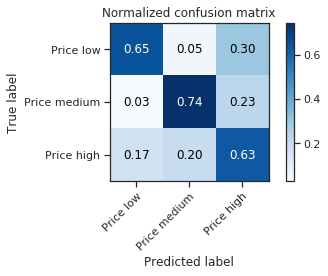

In [93]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
cm = plot_confusion_matrix(true, predicted, classes=['Price low','Price medium','Price high'], normalize=True)
print("{}".format(classification_report(true,predicted,target_names=['Price low','Price medium','Price high'])))

The model has difficulty to predict high price, overall the accuracy is pretty low, clustering of the prices should be revisited